In [33]:
# block 1: import all important libraries

%reset
%matplotlib inline
from netCDF4 import Dataset
from netCDF4 import num2date
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import numpy.ma as ma
from math import sqrt 
import matplotlib.dates as mdates

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [34]:
# block 2: Import the used data file and create a variable with the data in the file

data = "http://thredds.aodn.org.au/thredds/dodsC/IMOS/ABOS/DA/EAC1/Velocity/IMOS_ABOS-DA_AETVZ_20120421T130000Z_EAC1_FV01_EAC1-2012-WORKHORSE-ADCP-422_END-20130823T213855Z_C-20141016T011230Z.nc"
ADCPeac1 = Dataset(data)

In [35]:
# block 3: Extracting the U/V/lat/long/time/H_B_S/qc data from the import file and assigns them to a variable

#basic data 
TIMES = ADCPeac1.variables['TIME']
DEPTH = ADCPeac1.variables['DEPTH']
V = ADCPeac1.variables['VCUR']
U = ADCPeac1.variables['UCUR']
Wheight = ADCPeac1.variables['HEIGHT_ABOVE_SENSOR']

#quality control
hasqc = ADCPeac1.variables['HEIGHT_ABOVE_SENSOR_quality_control']
Vqc = ADCPeac1.variables['VCUR_quality_control']
Uqc = ADCPeac1.variables['UCUR_quality_control']
Dqc = ADCPeac1.variables['DEPTH_quality_control']

# To regrid for Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))             
Depth_i = 0                              
Depth_f = 500                              
Depth_dz = 10 

In [36]:
Vqc 

<class 'netCDF4._netCDF4.Variable'>
int8 VCUR_quality_control(TIME, HEIGHT_ABOVE_SENSOR, LATITUDE, LONGITUDE)
    _Unsigned: false
    long_name: quality flag for northward_sea_water_velocity
    standard_name: northward_sea_water_velocity status_flag
    valid_min: 0
    valid_max: 9
    _FillValue: 99
    quality_control_set: 1.0
    quality_control_conventions: IMOS standard set using the IODE flags
    flag_values: [0 1 2 3 4 5 6 7 8 9]
    flag_meanings: No_QC_performed Good_data Probably_good_data Bad_data_that_are_potentially_correctable Bad_data Value_changed Not_used Not_used Not_used Missing_value
    quality_control_global_conventions: Argo reference table 2a (see http://www.cmar.csiro.au/argo/dmqc/user_doc/QC_flags.html), applied on data in position only (between global attributes time_deployment_start and time_deployment_end)
    quality_control_global: B
    _ChunkSizes: [11886    30     1     1]
unlimited dimensions: 
current shape = (11886, 30, 1, 1)
filling off

In [37]:
#block 4: Convert the ADCP time serie dataset (Matlab to python time serie: yyyy/mm/dd hh/mm/ss)

unitseac1 = ADCPeac1.variables['TIME'].units
calendareac1 = ADCPeac1.variables['TIME'].calendar
timeseac1  = num2date(ADCPeac1.variables['TIME'][:], units=unitseac1, calendar=calendareac1)
times1 = mdates.date2num(timeseac1)

In [38]:
timeseac1

array([datetime.datetime(2012, 4, 20, 0, 0),
       datetime.datetime(2012, 4, 20, 0, 59, 59, 999997),
       datetime.datetime(2012, 4, 20, 2, 0, 0, 3), ...,
       datetime.datetime(2013, 8, 28, 3, 0),
       datetime.datetime(2013, 8, 28, 3, 59, 59, 999997),
       datetime.datetime(2013, 8, 28, 5, 0, 0, 3)], dtype=object)

In [39]:
#block 5: Create variables with ADCP dataset 

#basic data
depth_ADCP = DEPTH[:,0,0]
depth_Bin = Wheight[:]   
v2d = V[:,:,0,0]
u2d = U [:,:,0,0]

#quality controle data 
hasqc1 = hasqc[:]
Vqc1 = Vqc[:,:,0,0]
Uqc1 = Uqc[:,:,0,0]
Dqc1 = Dqc[:,0,0]

In [40]:
#block 4: Use the quality control data for clean the wrong values (wrong values = Nan)

depth_ADCP[Dqc1 != 1] = np.NaN 
Vqc2 = v2d
Vqc2[Vqc1 != 1] = np.NaN
Uqc2 = u2d
Uqc2[Uqc1 != 1] = np.NaN

In [41]:
#block 5: reshape the depth of the mooring and the depth above the sensor for having the same shape.

depth_ADCP30=np.transpose(np.kron(np.ones((len(Wheight),1)),depth_ADCP)) 
depth_ADCP30[depth_ADCP30 < 10] = np.NaN                       
depth_Bin_gridded=np.kron(np.ones((len(times1),1)),depth_Bin)

/home/z3525831/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [42]:
#block 6: Create the real depth variable.

DepthReal = depth_ADCP30-depth_Bin_gridded

In [43]:
np.shape(DepthReal)

(11886, 30)

In [44]:
#block 7: Create the good time and depth variable for the scatter plot.

Times_final = np.transpose(np.kron(np.ones((len(Wheight),1)),times1))

In [45]:
#V

In [46]:
# block 8: Use loop "for", for interpolate the new V variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               
V_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))

# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  

    to_Vqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    V_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    V_for_loop = Vqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(V_for_loop))    
    if ~np.isnan(V_for_loop).all():
        to_Vqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],V_for_loop[ind],left=np.NaN,right=np.NaN)
    V_interp_final[t,] = to_Vqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
V_interp_final_ma = np.ma.array (V_interp_final, mask=np.isnan(V_interp_final))

### Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #V_for_loop = Vqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(V_for_loop,Depth_For_loop,'ko-')
    #plt.plot(V_interp_final[t,:],Depth_interp_final,'bo-')

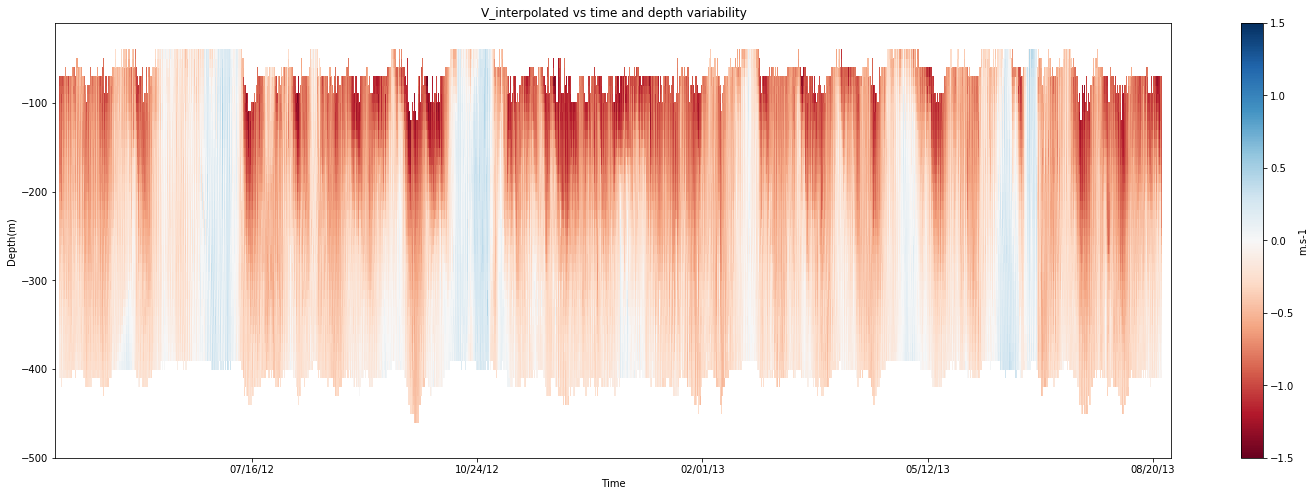

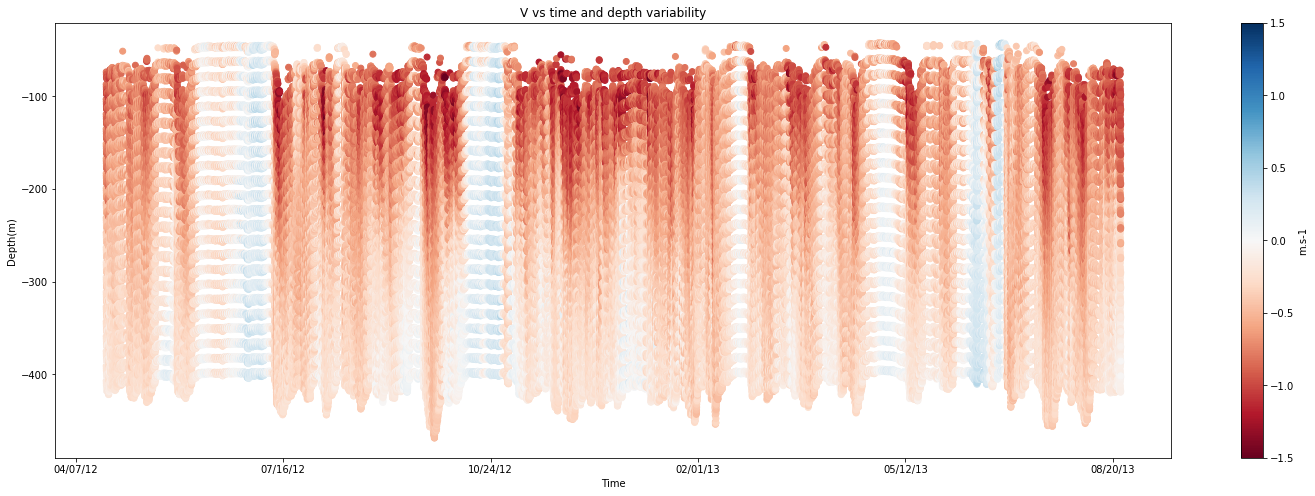

In [47]:
#block 9: Plot V vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,np.transpose(V_interp_final_ma),cmap='RdBu')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("V_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.clim(-1.5, 1.5)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Vqc2, cmap='RdBu')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("V vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.clim(-1.5, 1.5)
plt.show()

In [48]:
#U

In [49]:
# block 10: Use loop "for", for interpolat the U variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               # New depth grid
U_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))


# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  

    to_Uqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    U_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    U_for_loop = Uqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(U_for_loop))    
    if ~np.isnan(U_for_loop).all():
        to_Uqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],U_for_loop[ind],left=np.NaN,right=np.NaN)
    U_interp_final[t,] = to_Uqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
U_interp_final_ma = np.ma.array (U_interp_final, mask=np.isnan(U_interp_final))

# Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #U_for_loop = Uqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(U_for_loop,Depth_For_loop,'ko-')
    #plt.plot(U_interp_final[t,:],Depth_interp_final,'bo-')

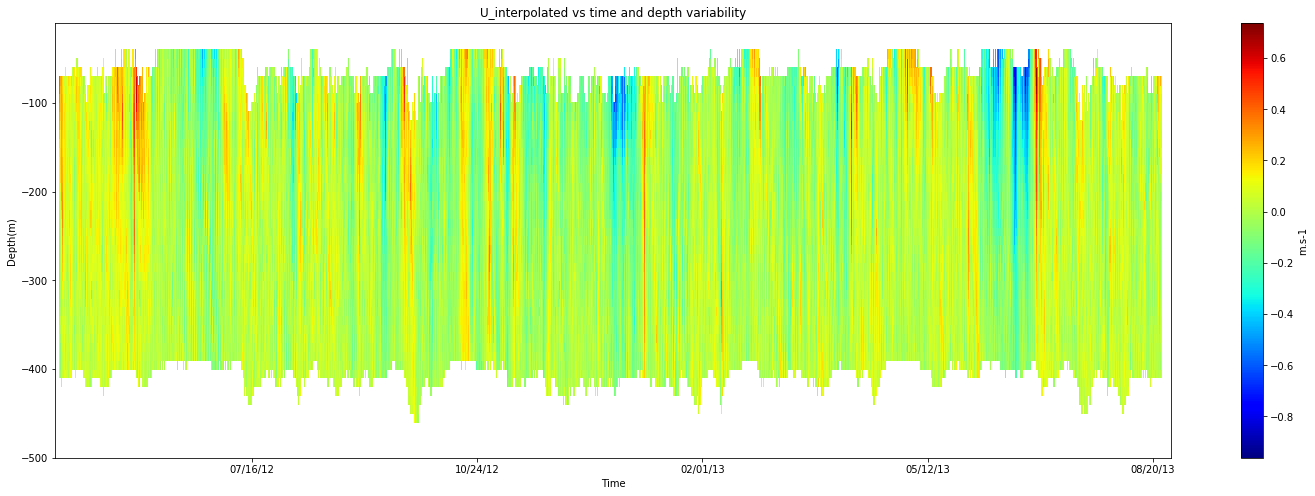

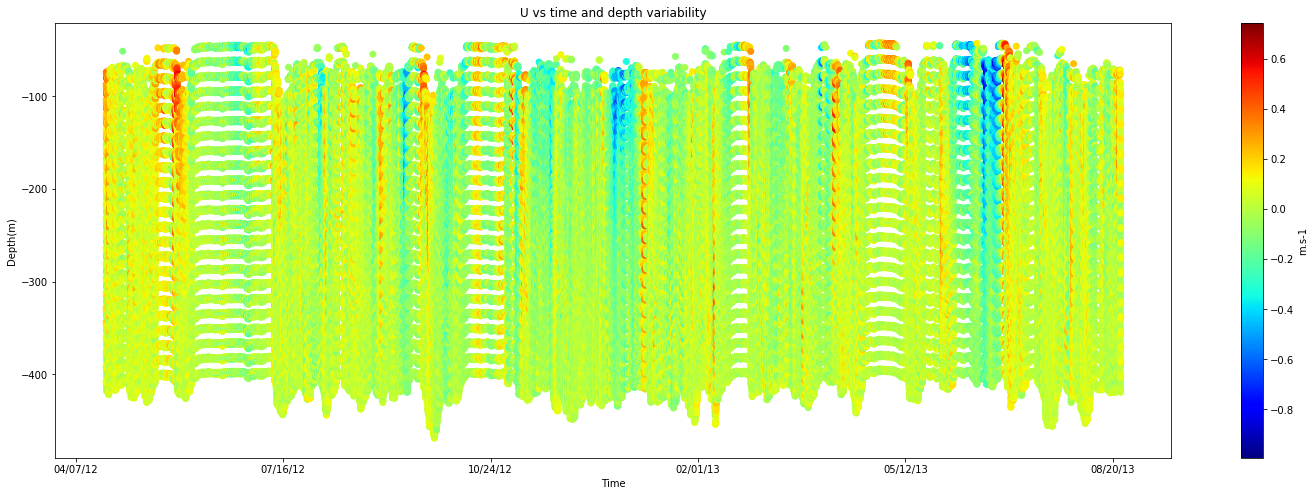

In [50]:
#block 11: Plot U vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,np.transpose(U_interp_final_ma),cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("U_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Uqc2, cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("U vs time and depth variability")
plt.show()

In [51]:
#Speed

In [52]:
#block 12: Create basic speed 

Speed = (Uqc2*Uqc2) + (Vqc2*Vqc2)
Speedf = np.sqrt(Speed)

In [53]:
#block 13: Create interpolate speed 

#rename U and V variables for the speed equation
U_interp_sp = np.transpose(U_interp_final_ma)
V_interp_sp = np.transpose(V_interp_final_ma)


Speed_interp = (U_interp_sp*U_interp_sp) + (V_interp_sp*V_interp_sp)
Speed_interp_final = np.sqrt(Speed_interp)

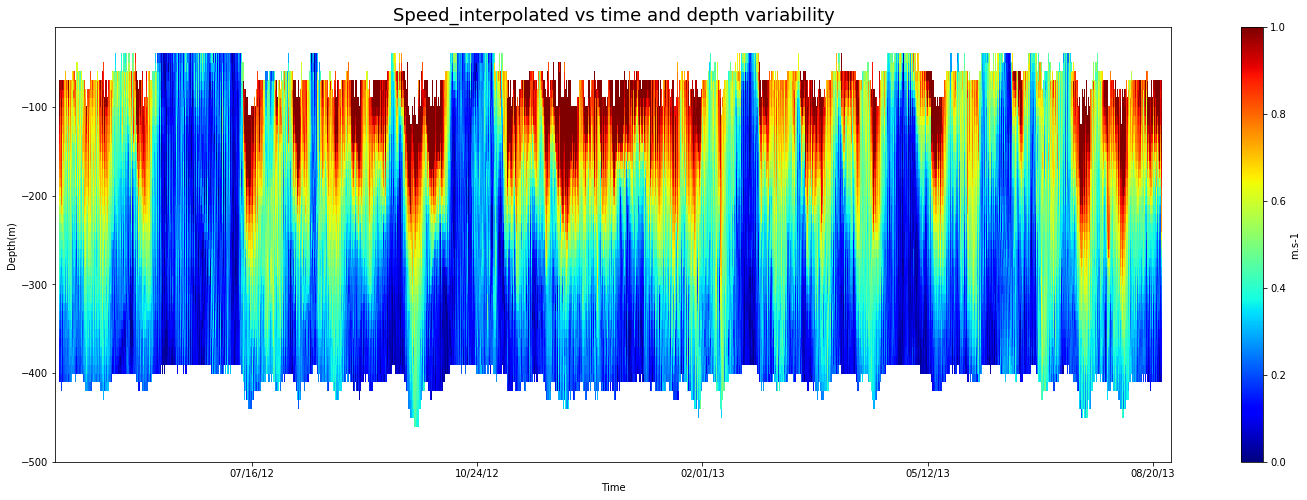

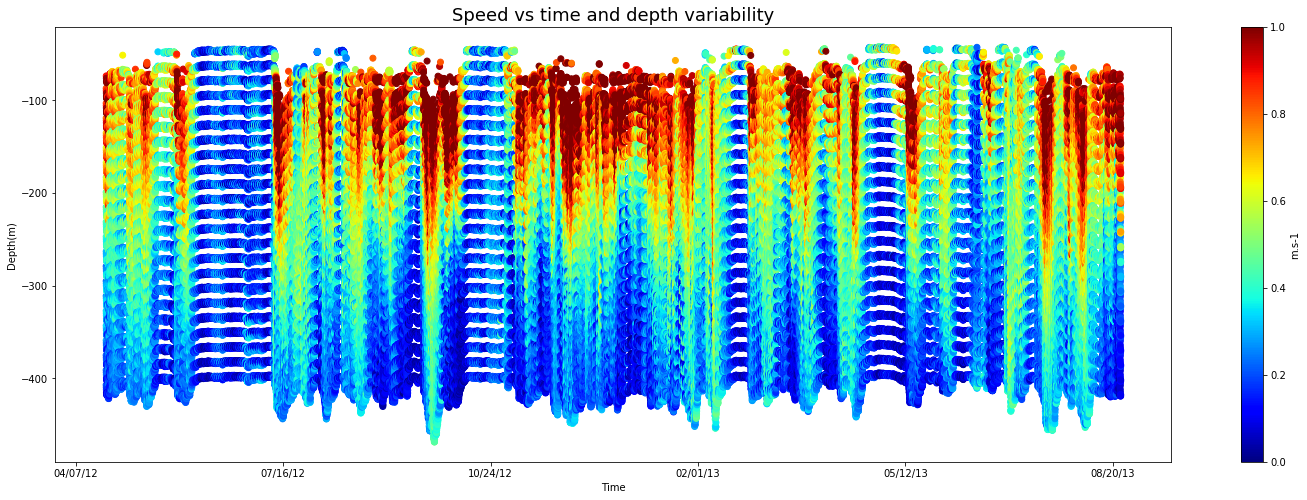

In [54]:
#block 14: Plot basic speed and interpolate speed vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,Speed_interp_final,cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed_interpolated vs time and depth variability",fontsize=18)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Speedf, cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed vs time and depth variability",fontsize=18)
plt.show()

In [55]:
#Power density

In [56]:
#block 15: Create basic power density

P = 0.5 * 1025* (Speedf**3)     
Pf = P/1000

In [57]:
#block 16: Create interpolate power density

Power_interpolation = 0.5 * 1025* (Speed_interp_final**3)     
Power_interplation_final = Power_interpolation/1000 # convert unit in kW

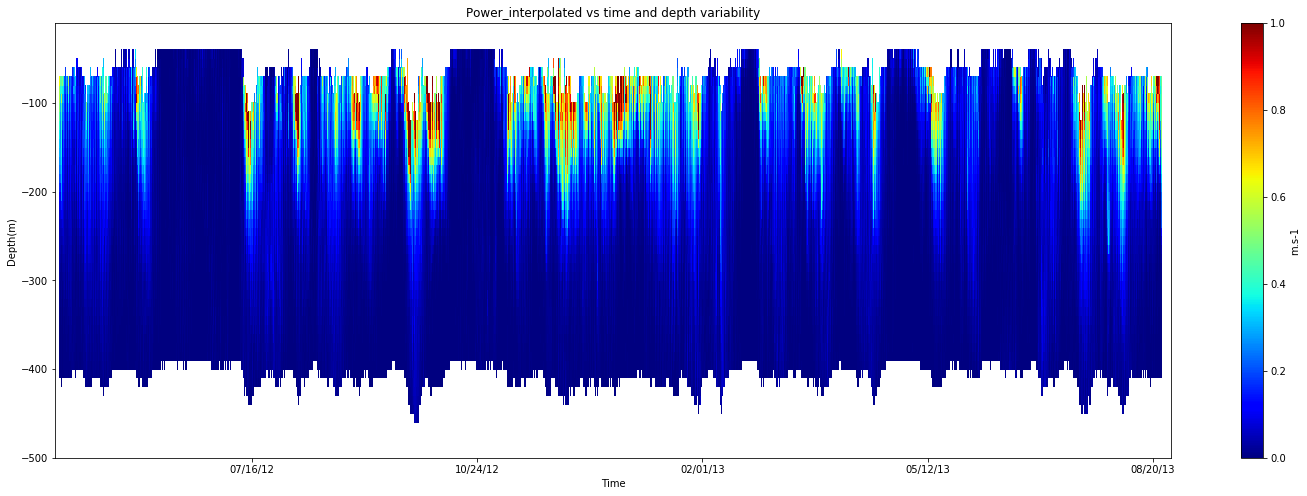

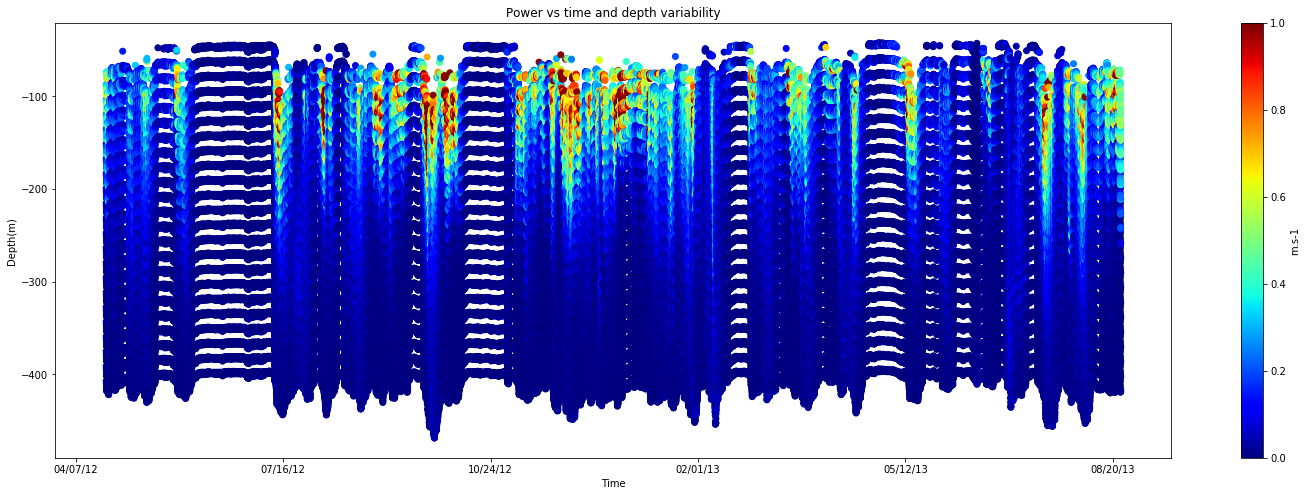

In [58]:
#block 17: Plot basic power density and interpolate power density vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,Power_interplation_final,cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Pf, cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power vs time and depth variability")
plt.show()

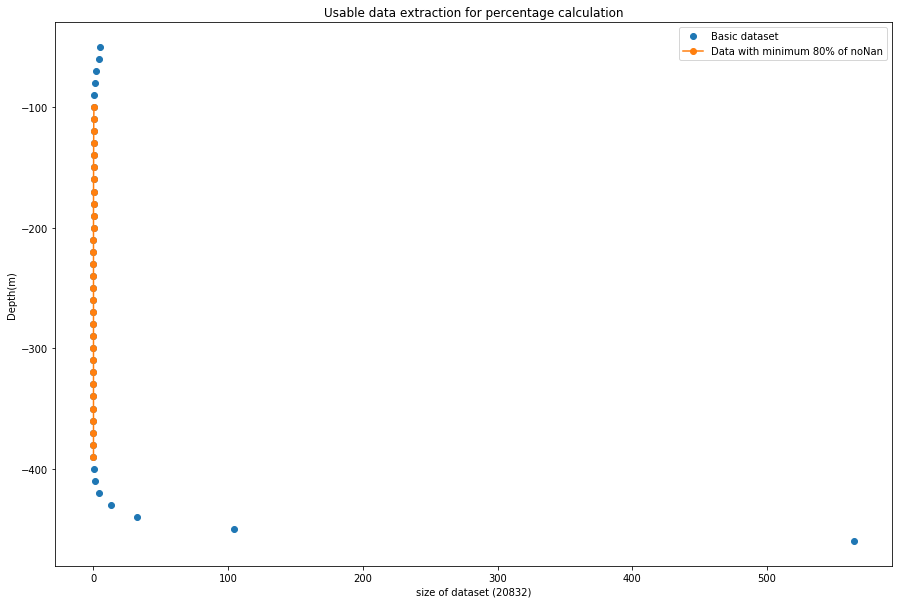

In [59]:
#block 18: use a "for" loop to calculate the percentage of power density interpolate above 0.5kW/m2 vs time and depth
#only noNan used

# Percentage of good data (no nan) for each depth
Depth_NoNans = ma.count(Power_interplation_final, axis=1)   # count non masks
Depth_Pourcentage_NoNans = ma.count(Power_interplation_final, axis=1)/len(times1)*100   # count non masks percentage

P_pourcentage_final = np.NaN + np.zeros(len(Depth_interp_final))
for z in range(len(Depth_interp_final)): 
    #print(z)
    ind, = np.where(Power_interplation_final[z,:] > 0.5)  # rentability
#    ind, = np.where(Power_interplation_final[z,:] > 0.064)  # rentability
    if Depth_NoNans[z]>0:
        P_pourcentage_final[z] = len(ind)/Depth_NoNans[z]

plt.figure(figsize=(15,10))
plt.plot(P_pourcentage_final,-Depth_interp_final,'o', label="Basic dataset") #plot basic data 
plt.plot(P_pourcentage_final[Depth_Pourcentage_NoNans>80],-Depth_interp_final[Depth_Pourcentage_NoNans>80],'-o', label="Data with minimum 80% of noNan")
plt.xlabel("size of dataset (20832)")             
plt.ylabel("Depth(m)")
plt.title("Usable data extraction for percentage calculation")
plt.legend() 
plt.show()

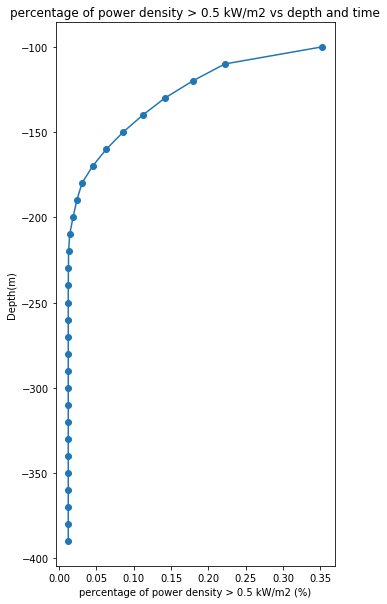

In [60]:
#block 19: Plot the percentage of power density > 0.5 kW/m2 vs depth and time

plt.figure(figsize=(5,10))
plt.plot(P_pourcentage_final[Depth_Pourcentage_NoNans>80],-Depth_interp_final[Depth_Pourcentage_NoNans>80],'-o')
plt.xlabel("percentage of power density > 0.5 kW/m2 (%)")             
plt.ylabel("Depth(m)")
plt.title("percentage of power density > 0.5 kW/m2 vs depth and time")
plt.show()

Text(0.5,1,'percentage of noNan')

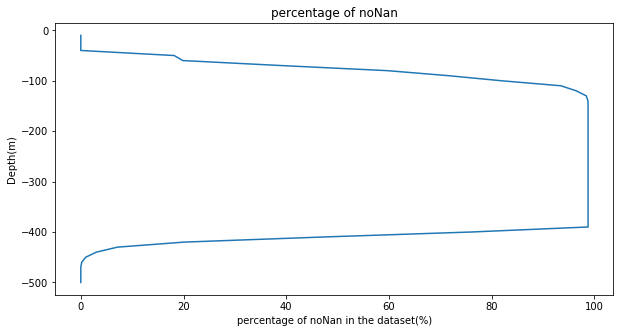

In [61]:
#block 20: Plot the percentage of noNan in the dataset vs depth
plt.figure(figsize=(10,5))
plt.plot(Depth_Pourcentage_NoNans,-Depth_interp_final)
plt.xlabel("percentage of noNan in the dataset(%)")             
plt.ylabel("Depth(m)")
plt.title("percentage of noNan")

In [62]:
#Plot basic pourcentage; compare the Strong current with the slow current.

In [63]:
#block 21: use a "for" loop to calculate the basic percentage of power density interpolate above 0.5kW/m2 vs time and depth

P_pourcentage_final = []

Depth_i_test = 20                              
Depth_f_test = 500                             
Depth_dz_test = 10 
Depth_interp_final_test = (np.arange(Depth_f_test,Depth_i_test,-Depth_dz_test))                               


for z in range(len(Depth_interp_final_test)): 
        Depth_Pourcentage = np.where(Power_interplation_final[z,:] > 0.5)         
        Depth_Pourcentage2 = np.array(Depth_Pourcentage)
        #print(np.shape(Depth_Pourcentage2.T))
        P_pourcentage = (len(Depth_Pourcentage2.T)*100)/20832
        P_pourcentage_final.append(P_pourcentage)

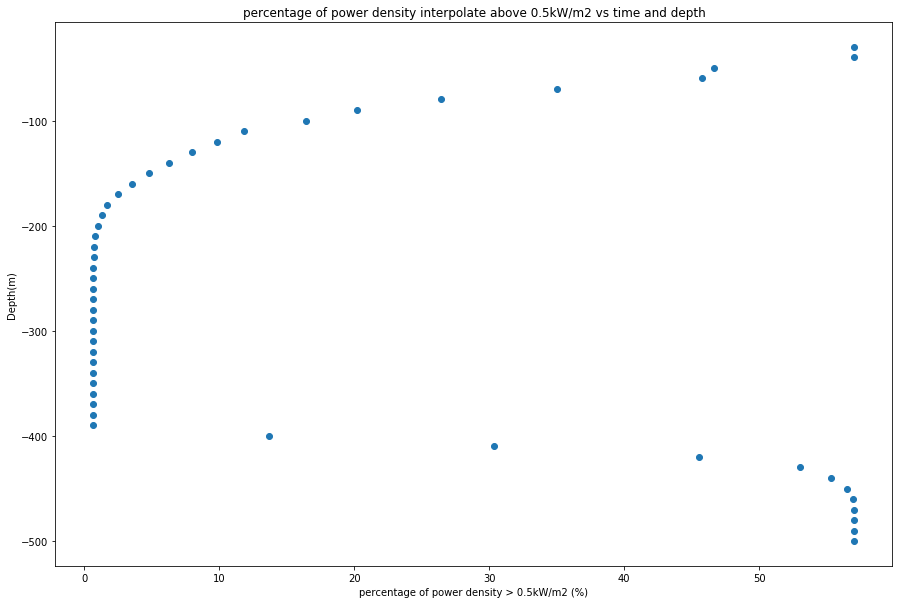

In [64]:
#block 22: PLot the basic percentage of power density interpolate above 0.5kW/m2 vs time and depth

plt.figure(figsize=(15,10))
plt.plot(P_pourcentage_final,-Depth_interp_final_test,'o')
plt.xlabel("percentage of power density > 0.5kW/m2 (%)")             
plt.ylabel("Depth(m)")
plt.title("percentage of power density interpolate above 0.5kW/m2 vs time and depth")
plt.show()